<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>


# Testing of web services deployed on ACI and AKS

## Table of content
1. [Introduction](#intro)
1. [Setup](#setup)
  1. [Library import](#imports)
  1. [Workspace retrieval](#workspace)
  1. [Service retrieval](#service)
1. [Testing of the web services](#testing)
  1. [Using the *run* API](#run)
  1. [Via a raw HTTP request](#request)
1. [Service telemetry in Application Insights](#insights)
1. [Clean up](#clean)
  1. [Application Insights deactivation and web service termination](#del_app_insights)
  1. [Docker image deletion](#del_image)

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/ComputerVision/classification/notebooks/23_aci_aks_web_service_testing.png)

## 1. Introduction <a id="intro"/>
In the 2 prior notebooks, we deployed our machine learning model as a web service on [Azure Container Instances](https://github.com/Microsoft/ComputerVisionBestPractices/blob/master/classification/notebooks/21_deployment_on_azure_container_instances.ipynb) (ACI) and on [Azure Kubernetes Service](https://github.com/Microsoft/ComputerVision/blob/master/classification/notebooks/22_deployment_on_azure_kubernetes_service.ipynb) (AKS). In this notebook, we will learn how to test our service:
- Using the `run` API
- Via a raw HTTP request.

<i><b>Note:</b> We are assuming that notebooks "20", "21" and "22" were previously run, and that we consequently already have a workspace, and a web service that serves our machine learning model on ACI and/or AKS. If that is not the case, we can refer to these three notebooks.</i>

## 2. Setup <a id="setup"/>

Let's start by retrieving all the elements we need; i.e. python libraries, Azure workspace and web services.

### 2.A Library import <a id="imports"/>

In [1]:
# For automatic reloading of modified libraries
%reload_ext autoreload
%autoreload 2

# Regular python libraries
import inspect
import json
import os
import requests
import sys

# fast.ai
from fastai.vision import open_image

# Azure
import azureml.core
from azureml.core import Workspace

# Computer Vision repository
sys.path.extend([".", "../.."])
from utils_cv.common.data import data_path
from utils_cv.common.image import im2base64, ims2strlist

# Check core SDK version number
print(f"Azure ML SDK Version: {azureml.core.VERSION}")

### 2.B Workspace retrieval <a id="workspace">

We get our workspace from the configuration file we created in notebook ["20"](https://github.com/Microsoft/ComputerVisionBestPractices/blob/master/classification/notebooks/20_azure_workspace_setup.ipynb), and that was saved in the `.azureml/` folder.

In [2]:
# Retrieve the workspace object
ws = Workspace.from_config()

# Print the workspace attributes
print('Workspace name: ' + ws.name, 
      'Workspace region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

### 2.C Service retrieval <a id="service">

If we have not deleted them in the 2 prior deployment notebooks, the web services we deployed on ACI and AKS should still be up and running. Let's check if that is indeed the case.

In [3]:
ws.webservices

{'im-classif-websvc': <azureml.core.webservice.aci.AciWebservice at 0x20c4ab270f0>,
 'aks-cpu-image-classif-web-svc': <azureml.core.webservice.aks.AksWebservice at 0x20c4ab27080>}

This command should return a dictionary, where the keys are the names we assigned to them.

Let's now retrieve the web services of interest.

In [4]:
# Retrieve the web services
aci_service = ws.webservices['im-classif-websvc']
aks_service = ws.webservices['aks-cpu-image-classif-web-svc']

## 3. Testing of the web services <a id="testing">

Let's now test our web service. For this, we first need to retrieve test images and to pre-process them into the format expected by our service. A service typically expects input data to be in a JSON serializable format. Here, we use our own `ims2strlist()` function to transform our .jpg images into strings of bytes.

In [5]:
# Check the source code of the conversion functions
im2base64_source = inspect.getsource(im2base64)
im2strlist_source = inspect.getsource(ims2strlist)
print(im2base64_source)
print(im2strlist_source)

In [6]:
# Extract test images paths
im_url_root = "https://cvbp.blob.core.windows.net/public/images/"
im_filenames = ["cvbp_milk_bottle.jpg", "cvbp_water_bottle.jpg"]

for im_filename in im_filenames:
    # Retrieve test images from our storage blob
    r = requests.get(os.path.join(im_url_root, im_filename))

    # Copy test images to local data/ folder
    with open(os.path.join(data_path(), im_filename), 'wb') as f:
        f.write(r.content)

# Extract local path to test images
local_im_paths = [os.path.join(data_path(), im_filename) for im_filename in im_filenames]

# Convert images to json object
im_string_list = ims2strlist(local_im_paths)
service_input = json.dumps({"data": im_string_list})

### 3.A Using the *run* API <a id="run">
    
In a real case scenario, we would only have one of these 2 services running. In this section, we show how to test that the web service running on ACI is working as expected. The commands we will use here are exactly the same as those we would use for our service running on AKS. We would just need to replace the `aci_service` object by the `aks_service` one.

In [7]:
# Select the web service to test
service = aci_service
# service = aks_service

In [8]:
# Predict using the deployed model
result = service.run(service_input)

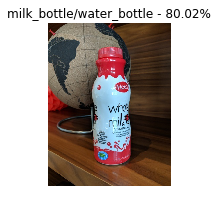

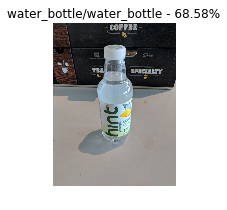

In [9]:
# Plot the results
actual_labels = ['milk_bottle', 'water_bottle']
for k in range(len(result)):
    title = f"{actual_labels[k]}/{result[k]['label']} - {round(100.*float(result[k]['probability']), 2)}%"
    open_image(local_im_paths[k]).show(title=title)

### 3.B Via a raw HTTP request <a id="request">

In the case of AKS, we need to provide an authentication key. So let's look at the 2 examples separately, with the same testing data as before.

In [10]:
# ---------
# On ACI
# ---------

# Extract service URL
service_uri = aci_service.scoring_uri
print(f"POST requests to url: {service_uri}")

# Prepare the data
payload = {"data": im_string_list}

# Send the service request
resp = requests.post(service_uri, json=payload)

# Alternative way of sending the test data
# headers = {'Content-Type':'application/json'}
# resp = requests.post(service_uri, service_input, headers=headers)

print(f"Prediction: {resp.text}")

Prediction: [{"label": "water_bottle", "probability": "0.8001841306686401"}, {"label": "water_bottle", "probability": "0.68577641248703"}]


In [11]:
# ---------
# On AKS
# ---------

# Service URL
service_uri = aks_service.scoring_uri
print(f"POST requests to url: {service_uri}")

# Prepare the data
payload = {"data": im_string_list}

# - - - - Specific to AKS - - - -
# Authentication keys
primary, secondary = aks_service.get_keys()
print(f"Keys to use when calling the service from an external app: {[primary, secondary]}")

# Build the request's parameters
key = primary
# Set the content type
headers = { 'Content-Type':'application/json' }
# Set the authorization header
headers['Authorization']=f'Bearer {key}'
# - - - - - - - - - - - - - - - -

# Send the service request
resp = requests.post(service_uri, json=payload, headers=headers)
# Alternative way of sending the test data
# resp = requests.post(service_uri, service_input, headers=headers)

print(f"Predictions: {resp.text}")

Predictions: [{"label": "water_bottle", "probability": "0.8001841306686401"}, {"label": "water_bottle", "probability": "0.68577641248703"}]


## 4. Service telemetry in [Application Insights](https://docs.microsoft.com/en-us/azure/azure-monitor/app/app-insights-overview) <a id="insights"/>

Let's now assume that we have users, and that they start sending requests to our web service. As they do so, we want to ensure that our service is up, healthy, returning responses in a timely fashion, and that traffic is reasonable for the resources we allocated to it. For this, we can use Application Insights. This service captures our web service's logs, parses them and provides us with tables and visual representations of what is happening.

In the [Azure portal](https://portal.azure.com):
- Let's navigate to "Resource groups"
- Select our subscription and resource group that contain our workspace
- Select the Application Insights type associated with our workspace
  * _If we have several, we can still go back to our workspace (in the portal) and click on "Overview" - This shows the elements associated with our workspace, in particular our Application Insights, on the upper right of the screen_
- Click on the App Insights resource
    - There, we can see a high level dashboard with information on successful and failed requests, server response time and availability (cf. Figure 1)
- Click on the "Server requests" graph
- In the "View in Analytics" drop-down, select "Request count" in the "Analytics" section
    - This displays the specific query ran against the service logs to extract the number of executed requests (successful or not -- cf. Figure 2).
- Still in the "Logs" page, click on the eye icon next to "requests" on the "Schema"/left pane, and on "Table", on the right:
    - This shows the list of calls to the service, with their success statuses, durations, and other metrics. This table is especially useful to investigate problematic requests (cf. Figure 3).
    - Results can also be visualized as a graph by clicking on the "Chart" tab. Metrics are plotted by default, but we can change them by clicking on one of the field name drop-downs (cf. Figures 4 to 6).
- Navigate across the different queries we ran through the different "New Query X" tabs.

<table>
<tr>
    <td>
        <img src="media/webservice_performance_metrics.jpg"  width="400"/>Figure 1: Web service performance metrics
    </td>
    <td>
        <img src="media/application_insights_all_charts.jpg" width="500"/>Figure 2: Insights into failed requests
    </td>
</tr>

<tr>
    <td>
        <img src="media/logs_failed_request_details.jpg" width="500"/>Figure 3: Example log of a failed request
    </td>
    <td>
        <img src="media/all_requests_line_chart.jpg"  width="400" alt="my alt text"/>Figure 4: Total request count over time
    </td>
</tr>


<tr>
    <td>
        <img src="media/failures_requests_line_chart.jpg" width="500"/>Figure 5: Failed request count over time
    </td>
    <td>
        <img src="media/success_status_bar_chart.jpg"  width="400" alt="my alt text"/>Figure 6: Request success distribution
    </td>
</tr>
</table>

## 5. Clean up <a id="clean">

In a real-life scenario, it is likely that one of our web services would need to be up and running at all times. However, in the present demonstrative case, and now that we have verified that they work, we can delete them as well as all the resources we used.

Overall, with a workspace, a web service running on ACI and another one running on a CPU-based AKS cluster, we incurred a cost of about $15 a day (as of May 2019). About 70% was spent on virtual machines, 13% on the container registry (ACR), 12% on the container instances (ACI), and 5% on storage.

To get a better sense of pricing, we can refer to [this calculator](https://azure.microsoft.com/en-us/pricing/calculator/?service=virtual-machines). We can also navigate to the [Cost Management + Billing pane](https://ms.portal.azure.com/#blade/Microsoft_Azure_Billing/ModernBillingMenuBlade/BillingAccounts) on the portal, click on our subscription ID, and click on the Cost Analysis tab to check our credit usage.

<i><b>Note:</b> In the next notebooks, we will continue to use the AKS web service. This is why we are only deleting the service deployed on ACI.</i>

### 5.A Application Insights deactivation and web service termination <a id="del_app_insights">

When deleting resources, we need to start by the ones we created last. So, we first deactivate the telemetry and then delete services and compute targets.

In [ ]:
# Telemetry deactivation
# aks_service.update(enable_app_insights=False)

# Services termination
aci_service.delete()
# aks_service.delete()

# Compute target deletion
# aks_target.delete()

### 5.B Docker image deletion <a id="del_image">

Now that the services no longer exist, we can delete the Docker image that we created in [21_deployment_on_azure_container_instances.ipynb](https://github.com/Microsoft/ComputerVisionBestPractices/blob/master/classification/notebooks/21_deployment_on_azure_container_instances.ipynb), and which contains our image classifier model.

In [ ]:
print("Docker images:")
for docker_im in ws.images:    
    print(f"    --> Name: {ws.images[docker_im].name}\n\
    --> ID: {ws.images[docker_im].id}\n\
    --> Tags: {ws.images[docker_im].tags}\n\
    --> Creation time: {ws.images[docker_im].created_time}")

In [ ]:
docker_image = ws.images["image-classif-resnet18-f48"]
# docker_image.delete()